### EDA

In [63]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
import seaborn as sns
import plotly_express as px
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from sklearn.model_selection import train_test_split as tts
from sklearn.neighbors import KNeighborsClassifier as KNNC
from PIL import Image

Loading dataset we'll be training with:

In [2]:
train = pd.read_csv('data/train.csv.zip')

In [3]:
train.shape #4167 rows & 74 columns
train.columns[:5]
train.shape

(4167, 74)

As it's quite large, let's tweak pd options to dive into our dataset comfortably. This way we can display columns/rows desired with no kind of restriction.

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
train.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [6]:
remain = ['host_since','host_is_superhost','host_total_listings_count']

In [7]:
drops = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name','host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month']

In [8]:
train.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,https://www.airbnb.com/rooms/2842228,20211205213126,2021-12-06,Your little appartment on wheels,A waggon luxurous designed as a hotel room on ...,"Waterland is a beautiful countryside area, wit...",https://a0.muscache.com/pictures/cc2aa51a-3c11...,3040748,https://www.airbnb.com/users/show/3040748,Henk,2012-07-24,"Amsterdam, North Holland, The Netherlands","Living in the countryside, just near Amsterdam...",within a few hours,100%,75%,f,https://a0.muscache.com/im/users/3040748/profi...,https://a0.muscache.com/im/users/3040748/profi...,NaN,13,13,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Amsterdam, North Holland, Netherlands",Noord-Oost,NaN,52.39508,4.99186,Private room in farm stay,Private room,3,NaN,1.5 shared baths,1.0,NaN,"[""First aid kit"", ""Free parking on premises"", ...",87.0,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,0,0,0,249,2021-12-06,81,0,0,2014-08-03,2019-06-15,4.62,4.56,4.29,4.57,4.75,4.69,4.49,0363 2A6D 7C09 877D 715F,f,10,0,10,0,0.91
1,1,https://www.airbnb.com/rooms/41236669,20211205213126,2021-12-06,Spacious 4p city center apartment (2 bedrooms!),Are you looking for a perfect place to stay in...,Our home is located in the Plantagebuurt. A un...,https://a0.muscache.com/pictures/5f33bf5a-399c...,34773624,https://www.airbnb.com/users/show/34773624,Julie,2015-06-01,"Amsterdam, Noord-Holland, Netherlands",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/a5da3...,https://a0.muscache.com/im/pictures/user/a5da3...,Weesperbuurt en Plantage,0,0,"['email', 'phone', 'reviews']",t,f,"Amsterdam, Noord-Holland, Netherlands",Centrum-Oost,NaN,52.36371,4.90745,Entire rental unit,Entire home/apt,4,NaN,1 bath,2.0,2.0,"[""Hot water kettle"", ""Pocket wifi"", ""Stove"", ""...",250.0,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,3,3,3,3,2021-12-06,9,4,1,2020-01-26,2021-09-05,5.00,5.00,5.00,4.89,5.00,5.00,4.89,0363 BD0E 9934 ACCA D3DE,f,1,1,0,0,0.40
2,2,https://www.airbnb.com/rooms/27240740,20211205213126,2021-12-06,SWEETS hotel Theophile de Bockbrug,Comfortable bridge house on the doorstep of Am...,"The neighbourhood has a quiet, village-like fe...",https://a0.muscache.com/pictures/b1145dd1-e485...,203731852,https://www.airbnb.com/users/show/203731852,SWEETS Hotel,2018-07-20,"Wassenaar, South Holland, Netherlands",SWEETS hotel is a one-of-a-kind hotel located ...,within an hour,100%,97%,t,https://a0.muscache.com/im/pictures/user/492cd...,https://a0.muscache.com/im/pictures/user/492cd...,Hoofddorppleinbuurt,20,20,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",Zuid,NaN,52.35482,4.85329,Room in serviced apartment,Hotel room,2,NaN,1 private bath,1.0,1.0,"[""Air conditioning"", ""First aid kit"",

In [9]:
compare = train[train['host_listings_count']== train['host_total_listings_count']]
compare[['host_listings_count','host_total_listings_count']].shape

#Las dos columnas son exactamente iguales, quitamos una

(4167, 2)

In [10]:
train.neighbourhood.nunique()#-->41 barrios!
print((train.neighbourhood.unique()))

['Amsterdam, North Holland, Netherlands'
 'Amsterdam, Noord-Holland, Netherlands' nan
 'Amsterdam, North-Holland, Netherlands' 'Amsterdam, NH, Netherlands'
 'Amsterdam, Netherlands' 'Netherlands'
 'Ouder-Amstel, Noord-Holland, Netherlands'
 'Amsterdam-Zuidoost, Noord-Holland, Netherlands'
 'Amsterdam, Haarlemmerbuurt, Netherlands'
 'Badhoevedorp, Noord-Holland, Netherlands'
 'Amsterdam-Zuidoost, North Holland, Netherlands'
 'Amsterdam, Frederiksstraat, Netherlands' 'Amsterdam, VX, Netherlands'
 'Amsterdam, Noord- Holland, Netherlands'
 'Amsterdam, The Netherlands, Netherlands'
 'Amsterdam, Netherlands, Netherlands'
 'Amsterdam Zuid-Oost, Noord-Holland, Netherlands'
 'Amsterdam, Noord-Holland 6, Netherlands'
 'Watergraafsmeer, North Holland, Netherlands'
 '1054 ZV, Noord-Holland, Netherlands'
 'Jordaan, North Holland, Netherlands'
 'Amsterdam, Nord Holland, Netherlands'
 'Amstelveen, Noord-Holland, Netherlands'
 'Amsterdam, Emmy andriessestraat, Netherlands'
 'Landsmeer, Noord-Holland, 

 ## Looking @ our target

In [11]:
train['price'].describe().T

count    4167.000000
mean      168.676986
std       180.658555
min         0.000000
25%        98.000000
50%       138.000000
75%       200.000000
max      6477.000000
Name: price, dtype: float64

In [12]:
int(train['price'].max()),int(train['price'].min()) # FREE acomodations!! yay!! - probably scrape errors

(6477, 0)

In [13]:
freebies = train[train['price'] == 0] #4 free acomodations
freebies.shape

(4, 74)

In [14]:
import seaborn as sn
import matplotlib.pyplot as plt

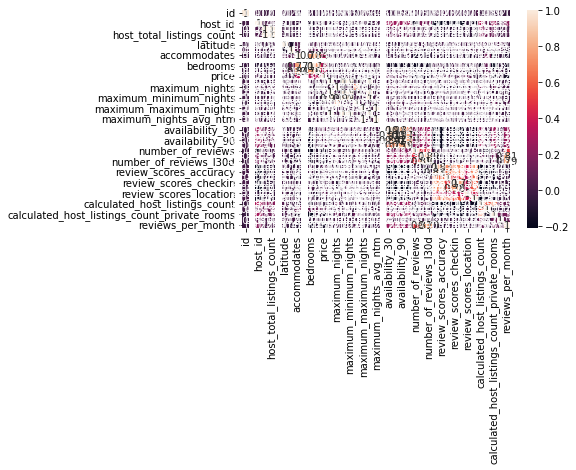

In [15]:
corrMatrix = train.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

## PLOTTING LOCATIONS MAP (Mapbox)

In [16]:
cortado = train[train['price']<200]
cortado.price.shape

(3110,)

In [65]:
px.scatter_geo(train,cortado.latitude,cortado.longitude, color=cortado.price ,fitbounds='locations')

In [18]:
train['geo'] = train['latitude'].map(str) + ',' + train['longitude'].map(str)
train['geo'].sample()

3657    52.3452,4.86311
Name: geo, dtype: object

In [19]:
#locator = Nominatim(user_agent='myGeocoder')
#coordinates = '53.480837, -2.244914' #EJEMPLO# 
#location = locator.reverse(coordinates)
#location.raw

In [20]:
geolocator = Nominatim(user_agent='myGeocoder')
location = geolocator.reverse

In [21]:
#location(train.geo[2]) #Funcionando

In [22]:
#NO RULA demasiado tiempo intentando obtener el dato

#train['address'] = train['geo'].apply(location)


Quick histplot of prices

In [23]:
#prices = pd.cut(train['price'],
#                bins = [0, 50, 100, 150, 200, 250, train["price"].max()],
#                labels=["0-50", "50-100", "100-150", "150-200", "200-250", "+250"])
# 
#prices.value_counts().sort_index().plot(kind="bar", rot = 0)#

In [24]:
#mayoria = train[train['price']<=250].shape[0]
#total = train.shape[0]
#mayoria/total #Casi el 87% de los precios estan por debajo de 250€

## DROPPING OUTLIERS:

In [25]:
#Esto no lo haremos sobre el test, solo para entreanar:
#def dropouts(df, column):
#    IQR = 1.5* (np.percentile(df[column],75)) - (np.percentile(df[column],25))
#    df.drop(df[df[column] > (IQR + np.percentile(df[column], 75))].index, inplace=True)
#    df.drop(df[df[column] < (np.percentile(df[column], 25)- IQR)].index, inplace=True)
#    print('Dropeados!')

In [26]:
#Nos cepillamos los outliers de price:
#dropouts(train, 'price')

In [27]:
###

In [28]:
train.shape

(4167, 75)

### LOOKING @ COLUMNS

How does our df's rows look like?
Just like <code>df.head(1)</code>, but nicer ;)

In [29]:
train.sample()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geo
3787,3787,https://www.airbnb.com/rooms/23334335,20211205213126,2021-12-05,Beautiful design apartment in famous Museum area!,Enjoy Amsterdam in the total comfort of your o...,The area of the apartment is a lively area wit...,https://a0.muscache.com/pictures/1e9fbcf1-95b6...,125660929,https://www.airbnb.com/users/show/125660929,Tom,2017-04-13,"Amsterdam, North Holland, Netherlands",NaN,NaN,NaN,NaN,t,https://a0.muscache.com/im/pictures/user/7c2ee...,https://a0.muscache.com/im/pictures/user/7c2ee...,De Pijp,1,1,"['email', 'phone', 'facebook', 'jumio', 'offli...",t,t,"Amsterdam, Noord-Holland, Netherlands",De Pijp - Rivierenbuurt,NaN,52.35576,4.88881,Entire rental unit,Entire home/apt,4,NaN,1 bath,2.0,2.0,"[""Luggage dropoff allowed"", ""Extra pillows and...",250.0,1,1125,1.0,2.0,1125.0,1125.0,1.4,1125.0,NaN,t,0,0,0,0,2021-12-05,36,0,0,2018-04-23,2020-01-19,4.92,4.94,4.94,5.0,5.0,4.92,4.56,0363 7BEE C197 947C BB19,f,1,1,0,0,0.82,"52.35576,4.88881"


In [30]:
#train.iloc[train['id'][0]] 

NaN values

In [31]:
nan_rank = train.isna().sum() #Most to least Nans columns
nan_rank[nan_rank.values > 0].sort_values(ascending=False)

neighbourhood_group_cleansed    4167
calendar_updated                4167
bathrooms                       4167
host_neighbourhood              1786
host_about                      1512
host_response_time              1413
host_response_rate              1413
neighbourhood                   1163
neighborhood_overview           1163
host_acceptance_rate            1092
review_scores_communication      385
review_scores_location           385
review_scores_value              385
review_scores_checkin            385
review_scores_accuracy           385
review_scores_cleanliness        385
first_review                     377
last_review                      377
reviews_per_month                377
review_scores_rating             377
bedrooms                         253
beds                             174
license                           32
host_location                     12
description                        8
bathrooms_text                     8
maximum_nights_avg_ntm             1
m

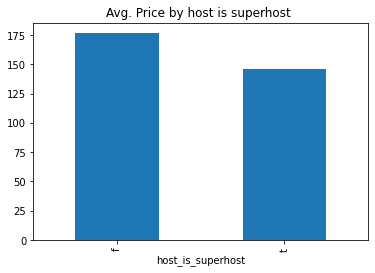

In [32]:
avg_price_superhost = train.groupby('host_is_superhost').mean()["price"]
avg_price_superhost.plot(kind="bar")
plt.title("Avg. Price by host is superhost ")
plt.show()

Al contrario de lo que podríamos esperar, el precio varía en funcion de si el host es Super o No pero
aunque de manera inversa a lo esperable

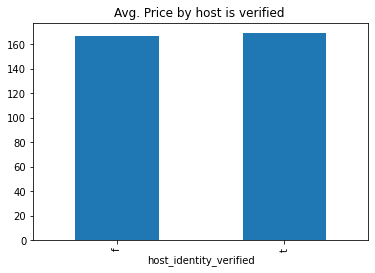

In [33]:
#plt.xticks(rotation=90)

avg_price_host_veri = train.groupby('host_identity_verified').mean()["price"]
avg_price_host_veri.plot(kind="bar")
plt.title("Avg. Price by host is verified ")
plt.show()

### ver como hacer casteo del host acceptance rate porque no me sale ni a palos

In [34]:
#train.host_acceptance_rate.astype(str)
#train.host_acceptance_rate.dtypes

#train.host_acceptance_rate = train.host_acceptance_rate.astype(str)#
#
#acc = pd.cut(train['host_acceptance_rate'],
#                bins = [0, 20, 40, 60, 80, 100],
#                labels=["0-20", "20-40", "40-60", "60-80", "80-100"])
# 
#acc.value_counts().sort_index().plot(kind="bar", rot = 0)

#avg_price_acc = train.groupby('host_acceptance_rate').mean()["price"]
#avg_price_host_veri.plot(kind="bar")
#plt.title("Avg. Price by host is verified ")
#plt.show()

In [35]:
type(train.host_acceptance_rate[0])

str

## CLUSTERIZANDO LATITUDE Y LONGITUD

### CON HDBSCAN

In [36]:
#0.01 / 6378

### HABLAR CON YONA PARA VER TEMA DE MANTENER LOS GRUPOS CLUSTERIZADOS ANTERIORMENTE:

In [37]:
#latitude y longitud los vamos a clusterizar con DBSCAN: --> METIDO EN UNA FUNCION
#!pip install hdbscan

#hdbscan=HDBSCAN(min_cluster_size=3,min_samples=2,cluster_selection_epsilon=0.01,
                #allow_single_cluster=False,prediction_data=True,leaf_size=30)
      
#help(hdbscan)
##PARAMS
#algorithm='best', alpha=1.0, approx_min_span_tree=True,
#    gen_min_span_tree=False, leaf_size=40, memory=Memory(cachedir=None),
#    metric='euclidean', min_cluster_size=5, min_samples=None, p=None

Cuales son la etiquetas de HDBSCAN??

In [38]:
#train.head()

In [39]:
#test=pd.read_csv('data/test.csv.zip') #Cargamos el test para ver como clusteriza los nuevos puntos

In [40]:
#test_points = np.column_stack((test['longitude'],test['latitude']))

In [41]:
#test_labels, strengths = hdbscan.prediction.approximate_predict(clasi, test_points)
#test_labels = clasi.approximate_predict(clasi, test_points)

In [42]:
#help(clasi)

### FUNCION LIMPIEZA:

In [43]:
import funciones as f

In [44]:
train.beds.isna().sum()

174

MIRAR BIEN LO DE CATS / QUE SOLO COGE EL PRIMER
MIRAR TB LO DE LOS AMENITIES QUE ME LOS HE CEPILLADO


In [45]:
#avg_price_host_since = train.groupby('host_since_year').mean()["price"]
#avg_price_host_since.plot(kind="bar")
#plt.title("Avg. Price by host since year")
#plt.show()

# H2O

In [46]:
train_ready = f.clean(train)
train_ready.columns

Index(['host_is_superhost', 'accommodates', 'beds', 'price', 'host_since_year',
       'Entire home/apt', 'Hotel room', 'Private room', 'Shared room'],
      dtype='object')

In [47]:
import h2o
from h2o.automl import H2OAutoML

In [48]:
h2o.init(
    nthreads=-1,     # number of threads when launching a new H2O server
    max_mem_size=8,# in gigabytes
)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.20.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.20.04, mixed mode, sharing)
  Starting server from /home/vp/miniconda3/envs/ironhack/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp1jxhk7sp
  JVM stdout: /tmp/tmp1jxhk7sp/h2o_vp_started_from_python.out
  JVM stderr: /tmp/tmp1jxhk7sp/h2o_vp_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_vp_kir8ca
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [49]:
train_H2o = h2o.H2OFrame(train_ready)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [50]:
y = "price" #Target a predecir
splits = train_H2o.split_frame(ratios = [0.85], seed = 42) #Hacemos tts a pelo
train = splits[0]
test = splits[1]

In [51]:
aml = H2OAutoML(seed=10, max_models = 30, max_runtime_secs = 100000000000000000099999999223500,
                max_runtime_secs_per_model = 999999999993600)
aml.train(y = y, training_frame = train, leaderboard_frame = test)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_1_20220224_220827_model_6


Model Summary: 


,,number_of_trees
0,,37.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 19469.361737325653
RMSE: 139.53265473474534
MAE: 57.25022902652018
RMSLE: 0.462865870333207
Mean Residual Deviance: 19469.361737325653

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 20907.58723192181
RMSE: 144.59456155721006
MAE: 58.57300420459323
RMSLE: 0.4712331683631688
Mean Residual Deviance: 20907.58723192181

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,58.571735,4.307446,57.216600,66.111220,56.871265,57.468180,55.191402
1,mean_residual_deviance,20900.110000,25800.486000,13650.137000,66837.850000,8628.698000,7290.172000,8093.694000
2,mse,20900.110000,25800.486000,13650.137000,66837.850000,8628.698000,7290.172000,8093.694000
3,r2,0.260827,0.134376,0.249004,0.042083,0.321339,0.401164,0.290544
4,residual_deviance,20900.110000,25800.486000,13650.137000,66837.850000,8628.698000,7290.172000,8093.694000
5,rmse,128.720440,73.579530,116.833800,258.530180,92.890785,85.382500,89.964960
6,rmsle,0.469908,0.039432,0.439024,0.450350,0.532056,0.485875,0.442234



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-02-24 22:09:46,17.306 sec,0.0,229.554992,166.737475,52695.494268
1,,2022-02-24 22:09:46,17.394 sec,5.0,151.960212,59.313814,23091.906142
2,,2022-02-24 22:09:46,17.456 sec,10.0,144.423623,56.822349,20858.183016
3,,2022-02-24 22:09:46,17.507 sec,15.0,142.737425,56.595268,20373.972588
4,,2022-02-24 22:09:46,17.579 sec,20.0,141.726958,56.885770,20086.530655
5,,2022-02-24 22:09:46,17.725 sec,25.0,140.983587,56.935179,19876.371665
6,,2022-02-24 22:09:46,17.804 sec,30.0,140.349979,56.806583,19698.116713
7,,2022-02-24 22:09:46,17.923 sec,35.0,139.702986,56.972399,19516.924339
8,,2022-02-24 22:09:46,17.956 sec,37.0,139.532655,57.250229,19469.361737



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,accommodates,8.263357e+06,1.000000,0.432116
1,beds,3.415027e+06,0.413274,0.178582
2,host_since_year,3.295873e+06,0.398854,0.172351
3,Entire home/apt,2.828004e+06,0.342234,0.147885
4,Private room,7.255444e+05,0.087803,0.037941
5,host_is_superhost,4.697392e+05,0.056846,0.024564
6,Hotel room,1.254822e+05,0.015185,0.006562


In [52]:
lb = aml.leaderboard
lb

perf = aml.leader.model_performance(test)



ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 71591.31569685583
RMSE: 267.5655353307967
MAE: 63.93011098554834
RMSLE: 0.43693202029443995
Mean Residual Deviance: 71591.31569685583


NameError: name 'gini' is not defined

In [53]:
#ENTRENAMIENTO CON DATA SET COMPLETO
#aml.leader.train(y = y, training_frame = train_H2o)

In [54]:
#test = pd.read_csv('data/test.csv.zip')

In [55]:
#f.clean(test)

In [56]:
#testh2o = h2o.H2OFrame(test)
#prediccion_test_completo = aml.leader.predict(testh2o)

In [57]:
#QUIETO

In [58]:
#predict = h2o.as_list(prediccion_test_completo)
#f.export(predict,'modelo7')

In [59]:
#predict.to_csv(("data/{}.csv".format(nombre)))
#sample = pd.read_csv('data/sample.csv')
#sample.price = predict.predict  #Cambiamos columna price por la Series de Pandas que tenemos
#sample.to_csv('data/modelo4_predict.csv', index = False)

In [60]:
#Viendo los insgiths de las columnas que me da modelo 4 me puedo cepillar la mitad

## PYCARET

In [61]:
from pycaret.regression import *

In [62]:
train_ready = f.clean(train)
train_ready.head()

AttributeError: 'H2OFrame' object has no attribute 'astype'

In [ ]:
#data = train_ready(frac=0.9, random_state=42)
#data_unseen = train_ready.drop(data.index)
#
#data.reset_index(drop=True, inplace=True)
#data_unseen.reset_index(drop=True, inplace=True)
#
#s = setup(data = data, target = 'price', session_id=123)#

In [ ]:
#f.clean(test)

## SGR

In [ ]:
train = pd.read_csv('data/train.csv.zip')
test = pd.read_csv('data/test.csv.zip')

In [ ]:
train_ready = f.clean(train)
train_ready.head()

In [ ]:
train_ready.columns

In [ ]:
test_ready = f.clean(test)
test_ready.shape

In [ ]:
from sklearn.linear_model import SGDRegressor as SGDR

X_train_d, X_test_d, y_train_d, y_test_d = tts(train_ready.drop('price', axis=1), 
                                               train_ready.price)

In [ ]:
sgdr=SGDR(max_iter=50000)

In [ ]:
def regre(modelo):
    
    modelo.fit(X_train_d, y_train_d)
    
    train_score = modelo.score(X_train_d, y_train_d)  # R2
    test_score = modelo.score(X_test_d, y_test_d)
    
    print(modelo)
    print('Train R2:', train_score)
    print('Test R2:', test_score)
    
    return modelo

In [ ]:
X_test_d.head()

In [ ]:
sgdr=regre(sgdr)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor as KNNR

In [ ]:
knnr=KNNR(n_neighbors=5, weights='distance')

knnr=regre(knnr)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

In [ ]:
gbr=GBR(n_estimators=200, learning_rate=0.03)

gbr=regre(gbr)

In [ ]:
EXPORTACION

In [ ]:
predict.to_csv(("data/{}.csv".format(nombre)))
sample = pd.read_csv('data/sample.csv')
sample.price = predict.predict  #Cambiamos columna price por la Series de Pandas que tenemos
sample.to_csv('data/modelo4_predict.csv', index = False)